# 2024-02-01 Dataset Cleaning

**Goal**: For each animal's scraped data from data.mat files, clean up the data to be ready for modeling.

Specifically, map column names and formats to things already used by the design_matrix_generator classes such that all code previously written for modeling is easy to adapt. Also, account for timeout trials (referred to as "trials not started") and drop them from the dataset. 

Related notebooks
* `2024_01_23_dev_new_dataset_cleaning.ipynb`

In [43]:
from multiglm.data import ANIMAL_IDS, COLUMN_RENAME
from multiglm.data.dataset_cleaner import clean_datasets

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
print(ANIMAL_IDS)

['W051', 'W060', 'W061', 'W062', 'W065', 'W066', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W084', 'W088', 'W089', 'W094']


In [7]:
all_animals_df = clean_datasets(ANIMAL_IDS, COLUMN_RENAME, save_out=True)

** RUNNING W051 **
** RUNNING W060 **
** RUNNING W061 **
** RUNNING W062 **
** RUNNING W065 **
** RUNNING W066 **
** RUNNING W074 **
** RUNNING W075 **
** RUNNING W078 **
** RUNNING W080 **
** RUNNING W081 **
** RUNNING W082 **
** RUNNING W083 **
** RUNNING W084 **
** RUNNING W088 **
** RUNNING W089 **
** RUNNING W094 **


In [60]:
all_animals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830195 entries, 0 to 2830194
Data columns (total 32 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   animal_id                 object        
 1   session_date              datetime64[ns]
 2   session_file_counter      int64         
 3   rig_id                    int64         
 4   training_stage            int64         
 5   s_a                       float64       
 6   s_b                       float64       
 7   hit                       float64       
 8   violation                 int64         
 9   trial_not_started         bool          
 10  s_a_sigma                 float64       
 11  rule                      object        
 12  correct_side              int64         
 13  violation_penalty_time    int64         
 14  error_penalty_time        int64         
 15  delayed_reward_time       float64       
 16  pre_stim_time             float64       
 17  s_a_time

In [11]:
all_animals_df.groupby("animal_id").trial_start_wait_time.value_counts()

animal_id  trial_start_wait_time
W051       200                      193053
W060       200                      148964
W061       200                       67452
           2000                      13722
W062       200                      136578
W065       200                      102602
W066       200                      171079
W074       200                      267349
W075       200                      276179
W078       200                      105740
W080       200                       94611
W081       200                      136679
W082       200                      322230
W083       200                      277357
W084       200                       61563
W088       200                      142400
W089       200                      180221
W094       200                      132416
Name: count, dtype: int64

array([[<Axes: title={'center': 'choice'}>]], dtype=object)

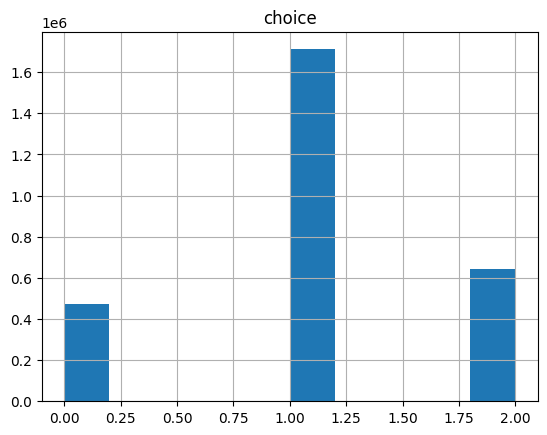

In [12]:
all_animals_df.hist(column="choice")

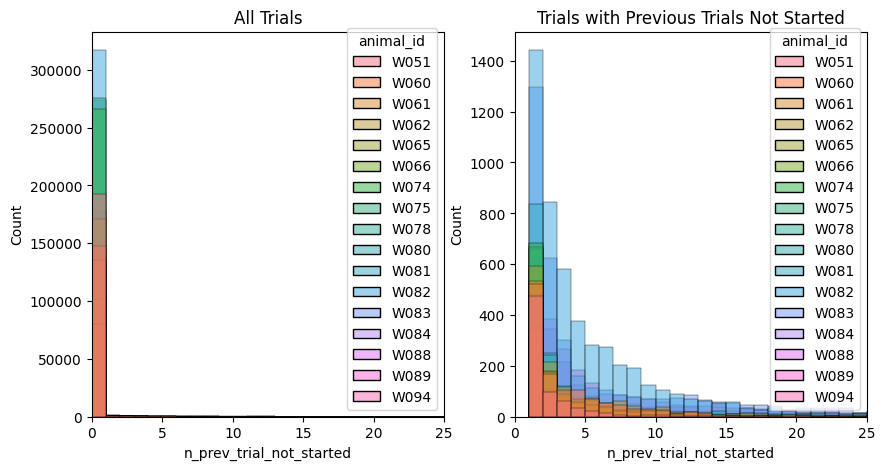

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    all_animals_df,
    x="n_prev_trial_not_started",
    hue="animal_id",
    binwidth=1,
    ax=ax[0],
)
_ = ax[0].set(title="All Trials", xlim=(0, 25))
sns.histplot(
    all_animals_df.query("n_prev_trial_not_started > 0"),
    x="n_prev_trial_not_started",
    hue="animal_id",
    binwidth=1,
    ax=ax[1],
)
_ = ax[1].set(title="Trials with Previous Trials Not Started", xlim=(0, 25))

In [14]:
all_animals_df.groupby("animal_id").violation.mean()

animal_id
W051    0.135471
W060    0.135429
W061    0.199436
W062    0.250655
W065    0.257003
W066    0.239340
W074    0.106602
W075    0.172653
W078    0.136817
W080    0.176407
W081    0.213990
W082    0.488400
W083    0.333761
W084    0.201988
W088    0.188132
W089    0.122849
W094    0.238030
Name: violation, dtype: float64

In [25]:
all_animals_df.groupby(
    ["animal_id", "session"]
).violation.mean().reset_index().violation.mean()

0.24397214912579798

In [26]:
all_animals_df.groupby(["animal_id", "session"]).hit.mean().reset_index().hit.mean()

0.753890507331365

It appears the variables look as normal. Timeouts (trial not started) are dropped but accounted for. Hit and violation rates looks in correct ranges. If I find something along the way, I will re-rerun this notebook and analyze it to indicate the change.